In [1]:
import locale
import matplotlib as mpl
from matplotlib import docstring
import numpy as np
import pandas as pd
import random
from matplotlib.projections.polar import PolarAxes
from numpy.lib.twodim_base import histogram2d
import matplotlib.pyplot as plt

In [2]:
ZBASE = -1000  # The starting zorder for all drawing, negative to have the grid on
VAR_DEFAULT = "speed"
DIR_DEFAULT = "direction"
FIGSIZE_DEFAULT = (8, 8)
DPI_DEFAULT = 80
CALM_CIRCLE_COLOR = "red"
CALM_CIRCLE_ALPHA = 0.4

In [3]:
class WindroseAxes(PolarAxes):
    """
    Create a windrose axes
    """

    name = "windrose"

    def __init__(self, *args, **kwargs):
        """
        See Axes base class for args and kwargs documentation
        """

        # Uncomment to have the possibility to change the resolution directly
        # when the instance is created
        # self.RESOLUTION = kwargs.pop('resolution', 100)
        self.rmax = kwargs.pop("rmax", None)
        PolarAxes.__init__(self, *args, **kwargs)
        self.set_aspect("equal", adjustable="box", anchor="C")
        self.radii_angle = 67.5
        self.cla()

    @staticmethod
    def from_ax(ax=None, fig=None, rmax=None, *args, **kwargs):
        """
        Return a WindroseAxes object for the figure `fig`.
        """
        if ax is None:
            if fig is None:
                fig = plt.figure(
                    figsize=FIGSIZE_DEFAULT,
                    dpi=DPI_DEFAULT,
                    facecolor="w",
                    edgecolor="w",
                )
            rect = [0.1, 0.1, 0.8, 0.8]
            ax = WindroseAxes(fig, rect, facecolor="w", rmax=rmax, *args, **kwargs)
            fig.add_axes(ax)
            return ax
        else:
            return ax

    def cla(self):
        """
        Clear the current axes
        """
        PolarAxes.cla(self)

        self.theta_angles = np.arange(0, 360, 45)
        self.theta_labels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
        self.set_thetagrids(angles=self.theta_angles, labels=self.theta_labels)

        self._info = {"dir": list(), "bins": list(), "table": list()}

        self.patches_list = list()

        self.calm_count = None

    def _colors(self, cmap, n):
        """
        Returns a list of n colors based on the colormap cmap
        """
        return [cmap(i) for i in np.linspace(0.0, 1.0, n)]

    def set_radii_angle(self, **kwargs):
        """
        Set the radii labels angle
        """

        kwargs.pop("labels", None)
        angle = kwargs.pop("angle", None)
        if angle is None:
            angle = self.radii_angle
        self.radii_angle = angle
        N = 5
        rmax = self.get_rmax()
        radii = np.linspace(0, rmax, N + 1)
        if rmax % N == 0:
            fmt = "%d"
        else:
            fmt = "%.1f"
        radii_labels = [fmt % r for r in radii]
        # radii_labels[0] = ""  # Removing label 0
        self.set_rgrids(
            radii=radii[1:], labels=radii_labels[1:], angle=self.radii_angle, **kwargs
        )

    def _update(self):
        if not self.rmax:
            self.rmax = np.max(np.sum(self._info["table"], axis=0))
        calm_count = self.calm_count or 0
        self.set_rmax(rmax=self.rmax + calm_count)
        self.set_radii_angle(angle=self.radii_angle)

    def legend(self, loc="lower left", decimal_places=1, **kwargs):
        """
        Sets the legend location and her properties.
        Parameters
        ----------
        loc : int, string or pair of floats, default: 'lower left'
            see :obj:`matplotlib.pyplot.legend`.
        decimal_places : int, default 1
            The decimal places of the formated legend
        Other Parameters
        ----------------
        isaxes : boolean, default True
            whether this is an axes legend
        prop : FontProperties(size='smaller')
            the font property
        borderpad : float
            the fractional whitespace inside the legend border
        shadow : boolean
            if True, draw a shadow behind legend
        labelspacing : float, 0.005
            the vertical space between the legend entries
        handlelenght : float, 0.05
            the length of the legend lines
        handletextsep : float, 0.02
            the space between the legend line and legend text
        borderaxespad : float, 0.02
            the border between the axes and legend edge
        kwarg
            Every other kwarg argument supported by
            :obj:`matplotlib.pyplot.legend`
        """

        def get_handles():
            handles = list()
            for p in self.patches_list:
                if isinstance(p, mpl.patches.Polygon) or isinstance(
                    p, mpl.patches.Rectangle
                ):
                    color = p.get_facecolor()
                elif isinstance(p, mpl.lines.Line2D):
                    color = p.get_color()
                else:
                    raise AttributeError("Can't handle patches")
                handles.append(
                    mpl.patches.Rectangle(
                        (0, 0), 0.2, 0.2, facecolor=color, edgecolor="black"
                    )
                )
            return handles

        def get_labels(decimal_places=1):
            _decimal_places = str(decimal_places)

            fmt = "[%." + _decimal_places + "f " + ": %0." + _decimal_places + "f"

            labels = np.copy(self._info["bins"])
            if locale.getlocale()[0] in ["fr_FR"]:
                fmt += "["
            else:
                fmt += ")"

            labels = [fmt % (labels[i], labels[i + 1]) for i in range(len(labels) - 1)]
            return labels

        kwargs.pop("labels", None)
        kwargs.pop("handles", None)

        # decimal_places = kwargs.pop('decimal_places', 1)

        handles = get_handles()
        labels = get_labels(decimal_places)
        self.legend_ = mpl.legend.Legend(self, handles, labels, loc, **kwargs)
        return self.legend_

    def set_legend(self, **pyplot_arguments):
        if "borderaxespad" not in pyplot_arguments:
            pyplot_arguments["borderaxespad"] = -0.10
        legend = self.legend(**pyplot_arguments)
        plt.setp(legend.get_texts(), fontsize=8)
        return legend

    def _init_plot(self, direction, var, **kwargs):
        """
        Internal method used by all plotting commands
        Parameters
        ----------
        direction : 1D array,
            directions the wind blows from, North centred
        var : 1D array,
            values of the variable to compute. Typically the wind speeds
        Other Parameters
        ----------------
        normed : boolean, default False
        blowto : boolean, default False
        colors : str or list of str, default None
            The colors of the plot.
        cmap : color map, default `jet`
            A :obj:`matplotlib.cm` colormap for the plot.
            Warning! It overrides `colors`.
        weibull_factors :
        mean_values :
        frequency :
        kwarg
            Any argument accepted by :obj:`matplotlib.pyplot.plot`.
        """

        # if weibull factors are entered overwrite direction and var
        if "weibull_factors" in kwargs or "mean_values" in kwargs:
            if "weibull_factors" in kwargs and "mean_values" in kwargs:
                raise TypeError("cannot specify both weibull_factors and mean_values")
            statistic_type = "unset"
            if "weibull_factors" in kwargs:
                statistic_type = "weibull"
                val = kwargs.pop("weibull_factors")
            elif "mean_values" in kwargs:
                statistic_type = "mean"
                val = kwargs.pop("mean_values")
            if val:
                if "frequency" not in kwargs:
                    raise TypeError(
                        "specify 'frequency' argument for statistical input"
                    )
                windFrequencies = kwargs.pop("frequency")
                if len(windFrequencies) != len(direction) or len(direction) != len(var):
                    if len(windFrequencies) != len(direction):
                        raise TypeError("len(frequency) != len(direction)")
                    elif len(direction) != len(var):
                        raise TypeError("len(frequency) != len(direction)")
                windSpeeds = []
                windDirections = []
                for dbin in range(len(direction)):
                    for _ in range(int(windFrequencies[dbin] * 10000)):
                        if statistic_type == "weibull":
                            windSpeeds.append(
                                random.weibullvariate(var[dbin][0], var[dbin][1])
                            )
                        elif statistic_type == "mean":
                            windSpeeds.append(
                                random.weibullvariate(var[dbin] * 2 / np.sqrt(np.pi), 2)
                            )
                        windDirections.append(direction[dbin])
                var, direction = windSpeeds, windDirections

        # self.cla()
        kwargs.pop("zorder", None)

        # Init of the bins array if not set
        bins = kwargs.pop("bins", None)
        if bins is None:
            bins = np.linspace(np.min(var), np.max(var), 6)
        if isinstance(bins, int):
            bins = np.linspace(np.min(var), np.max(var), bins)
        bins = np.asarray(bins)
        nbins = len(bins)

        # Number of sectors
        nsector = kwargs.pop("nsector", None)
        if nsector is None:
            nsector = 12

        # Sets the colors table based on the colormap or the "colors" argument
        colors = kwargs.pop("colors", None)
        cmap = kwargs.pop("cmap", None)
        if colors is not None:
            if isinstance(colors, str):
                colors = [colors] * nbins
            if isinstance(colors, (tuple, list)):
                if len(colors) != nbins:
                    raise ValueError("colors and bins must have same length")
        else:
            if cmap is None:
                cmap = mpl.cm.jet
            colors = self._colors(cmap, nbins)

        # Building the angles list
        angles = np.arange(0, -2 * np.pi, -2 * np.pi / nsector) + np.pi / 2

        normed = kwargs.pop("normed", False)
        blowto = kwargs.pop("blowto", False)

        # Calm condition
        calm_limit = kwargs.pop("calm_limit", None)
        if calm_limit is not None:
            mask = var > calm_limit
            self.calm_count = len(var) - np.count_nonzero(mask)
            if normed:
                self.calm_count = self.calm_count * 100 / len(var)
            var = var[mask]
            direction = direction[mask]

        # Set the global information dictionnary
        self._info["dir"], self._info["bins"], self._info["table"] = histogram(
            direction, var, bins, nsector, normed, blowto
        )

        return bins, nbins, nsector, colors, angles, kwargs

    def _calm_circle(self):
        """
        Draw the calm centered circle
        and return the initial offset for plots methods
        """
        if self.calm_count and self.calm_count > 0:
            circle = mpl.patches.Circle(
                (0., 0.),
                self.calm_count,
                transform=self.transData._b,
                color=CALM_CIRCLE_COLOR,
                alpha=CALM_CIRCLE_ALPHA,
            )
            self.add_artist(circle)
        return self.calm_count or 0


    def bar(self, direction, var, **kwargs):
        """
        Plot a windrose in bar mode. For each var bins and for each sector,
        a colored bar will be draw on the axes.
        Parameters
        ----------
        direction : 1D array
            directions the wind blows from, North centred
        var : 1D array
            values of the variable to compute. Typically the wind speeds.
        Other Parameters
        ----------------
        nsector : integer, optional
            number of sectors used to compute the windrose table. If not set,
            nsectors=12, then each sector will be 360/12=22.5°, and the
            resulting computed table will be aligned with the cardinals points.
        bins : 1D array or integer, optional
            number of bins, or a sequence of bins variable. If not set, bins=6
            between min(`var`) and max(`var`).
        blowto : bool, optional.
            if True, the windrose will be pi rotated, to show where the wind
            blow to (usefull for pollutant rose).
        colors : string or tuple, optional
            one string color ('k' or 'black'), in this case all bins will be
            plotted in this color; a tuple of matplotlib color args (string,
            float, rgb, etc), different levels will be plotted
            in different colors in the order specified.
        cmap : a cm Colormap instance from :obj:`matplotlib.cm`, optional.
            if cmap == None and colors == None, a default Colormap is used.
        edgecolor : string, optional
            The string color each edge box will be plotted.
            Default : no edgecolor
        opening : float, optional
            between 0.0 and 1.0, to control the space between each sector (1.0
            for no space)
        """

        bins, nbins, nsector, colors, angles, kwargs = self._init_plot(
            direction, var, **kwargs
        )
        kwargs.pop("facecolor", None)
        edgecolor = kwargs.pop("edgecolor", None)
        if edgecolor is not None:
            if not isinstance(edgecolor, str):
                raise ValueError("edgecolor must be a string color")
        opening = kwargs.pop("opening", None)
        if opening is None:
            opening = 0.8
        dtheta = 2 * np.pi / nsector
        opening = dtheta * opening

        offs = self._calm_circle()

        for j in range(nsector):
            offset = offs
            for i in range(nbins):
                if i > 0:
                    offset += self._info["table"][i - 1, j]
                val = self._info["table"][i, j]
                zorder = ZBASE + nbins - i
                patch = mpl.patches.Rectangle(
                    (angles[j] - opening / 2, offset),
                    opening,
                    val,
                    facecolor=colors[i],
                    edgecolor=edgecolor,
                    zorder=zorder,
                    **kwargs
                )
                self.add_patch(patch)
                if j == 0:
                    self.patches_list.append(patch)
        self._update()

def histogram(direction, var, bins, nsector, normed=False, blowto=False):
    if len(var) != len(direction):
        raise ValueError("var and direction must have same length")

    angle = 360. / nsector

    dir_bins = np.arange(-angle / 2, 360. + angle, angle, dtype=np.float)
    dir_edges = dir_bins.tolist()
    dir_edges.pop(-1)
    dir_edges[0] = dir_edges.pop(-1)
    dir_bins[0] = 0.

    var_bins = bins.tolist()
    var_bins.append(np.inf)

    if blowto:
        direction = direction + 180.
        direction[direction >= 360.] = direction[direction >= 360.] - 360

    table = histogram2d(x=var, y=direction, bins=[var_bins, dir_bins], normed=False)[0]
    # add the last value to the first to have the table of North winds
    table[:, 0] = table[:, 0] + table[:, -1]
    # and remove the last col
    table = table[:, :-1]
    if normed:
        table = table * 100 / table.sum()

    return dir_edges, var_bins, table

In [4]:
mydata = pd.read_csv("mydata.csv")

In [6]:
pm10 = mydata.pm10
o3 = mydata.o3
ws = mydata.ws
wd = mydata.wd
nox = mydata.nox
no2 = mydata.no2
pm25 = mydata.pm25

In [8]:
pollutant = input ("Enter pollutant for windrose:") 
if pollutant == "pm25":
    pollutant = pm25
elif pollutant == "pm10":
    pollutant = pm10
elif pollutant == "nox":
    pollutant = nox
elif pollutant == "no2":
    pollutant = no2

Enter pollutant for windrose:pm25


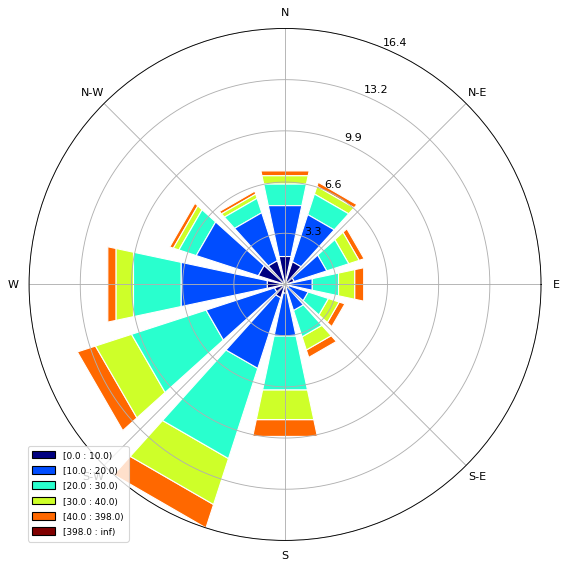

In [9]:
ax = WindroseAxes.from_ax()
ax.bar(wd, pollutant, normed=True,opening=0.8, edgecolor='white', bins = [0,10,20,30,40,398], cmap = plt.cm.jet)
mean_values = True
ax.set_legend()